In [1]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  

</style>

In [3]:
import datetime
import pyaurorax
import cartopy.crs

aurorax = pyaurorax.PyAuroraX()
at = aurorax.tools

### **Step 1: Download and Read Necessary Data**

***We will download both THEMIS and TREx RGB data here.***

In [4]:
# download a minute of RGB data from several sites
dataset_name = "TREX_RGB_RAW_NOMINAL"
start_dt = datetime.datetime(2023, 2, 24, 6, 15)
end_dt = start_dt
rgb_site_uid_list = ['yknf', 'gill', 'rabb', 'luck']
data_list = []
data_download_objs = {}
for site_uid in rgb_site_uid_list:
    download_obj = aurorax.data.ucalgary.download(dataset_name, start_dt, end_dt, site_uid=site_uid)
    data_download_objs[site_uid] = download_obj

# Read in the data site-by-site, as we need this separation for mosaicing
for site_uid, download_obj in data_download_objs.items():
    data_list.append(aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames))

# Now download a minute of THEMIS data from the same time
dataset_name = "THEMIS_ASI_RAW"
start_dt = datetime.datetime(2023, 2, 24, 6, 15)
end_dt = start_dt
themis_site_uid_list = ['fsmi', 'atha']
data_download_objs = {}
for site_uid in themis_site_uid_list:
    download_obj = aurorax.data.ucalgary.download(dataset_name, start_dt, end_dt, site_uid=site_uid)
    data_download_objs[site_uid] = download_obj

# Read in and append to the SAME data_list
for site_uid, download_obj in data_download_objs.items():
    data_list.append(aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames))

### **Step 2: Download Skymaps**

In [6]:
# Initialize our total skymap data list
skymaps = []

# Get the recommended skymap for RGB data, read it in
for site_uid in rgb_site_uid_list:
    download_obj = aurorax.data.ucalgary.download_best_skymap("TREX_RGB_SKYMAP_IDLSAV", site_uid, start_dt)
    skymap = aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames[0])
    skymaps.append(skymap.data[0])

# Get the recommended skymap for THEMIS data, read it in
skymap_download_objs = {}
for site_uid in themis_site_uid_list:
    download_obj = aurorax.data.ucalgary.download_best_skymap("THEMIS_ASI_SKYMAP_IDLSAV", site_uid, start_dt)
    skymap = aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames[0])
    skymaps.append(skymap.data[0])

skymaps

[Skymap(project_uid=rgb, site_uid=yknf, imager_uid=rgb-08, site_map_latitude=62.519848, site_map_longitude=245.686966, ...),
 Skymap(project_uid=rgb, site_uid=gill, imager_uid=rgb-04, site_map_latitude=56.376724, site_map_longitude=265.356323, ...),
 Skymap(project_uid=rgb, site_uid=rabb, imager_uid=rgb-06, site_map_latitude=58.227810, site_map_longitude=256.319366, ...),
 Skymap(project_uid=rgb, site_uid=luck, imager_uid=rgb-03, site_map_latitude=51.153988, site_map_longitude=252.735260, ...),
 Skymap(project_uid=themis, site_uid=fsmi, imager_uid=themis10, site_map_latitude=60.026112, site_map_longitude=248.067062, ...),
 Skymap(project_uid=themis, site_uid=atha, imager_uid=themis02, site_map_latitude=54.602631, site_map_longitude=246.355728, ...)]

### **Step 3: Prep Skymap and Image Data**

In [7]:
# prepare the skymap data
prepped_skymap = at.mosaic.prep_skymaps(skymaps, 110, n_parallel=5)
prepped_skymap

Preparing skymaps:   0%|          | 0/6 [00:00<?, ?skymap/s]

MosaicSkymap(polyfill_lat=array(dims=(5, 265440),(5, 65536), dtype=float64), polyfill_lon=array(dims=(5, 265440),(5, 65536), dtype=float64), elevation=array(dims=(265440,),(65536,), dtype=>f4), site_uid_list=['yknf', 'gill', 'rabb', 'luck', 'fsmi', 'atha'])

In [8]:
# prepare the image data
prepped_images = at.mosaic.prep_images(data_list)
prepped_images

MosaicData(images=Dict[6 sites of array(dims=(480, 553),(256, 256))], timestamps=[20 timestamps], site_uid_list=['yknf', 'gill', 'rabb', 'luck', 'fsmi', 'atha'])

### **Step 4: Generate the Mosaic**

In [9]:
# define the intensity scales for each site
scale = {
    "yknf": [10, 105],
    "gill": [10, 105],
    "rabb": [10, 105],
    "luck": [10, 105],
    "atha": [3500, 14000],
    "fsmi": [3500, 14000],
}

# create projection
center_lat = -100.0
center_lon = 55.0
projection_obj = cartopy.crs.NearsidePerspective(central_longitude=center_lat, central_latitude=center_lon)

# create mosaic
frame_num = 0
mosaic = at.mosaic.create(prepped_images, prepped_skymap, frame_num, projection_obj, image_intensity_scales=scale)
print(mosaic)

Mosaic(polygon_data=PolyCollection(...), cartopy_projection=Projection(+proj=nsper +a=6378137.0 +lon_0=-100.0 +lat_0=55.0 +h=35785831 +x_0=0 +y_0=0 +units=m +no_defs +type=crs))


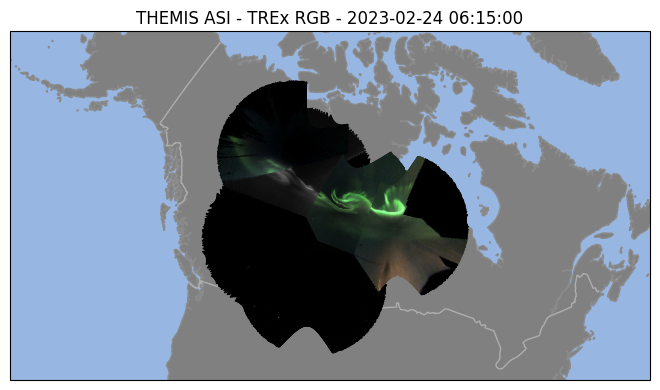

In [10]:
# plot mosaic
map_extent = [-145, -65, 35, 70]
mosaic.plot(map_extent, title="THEMIS ASI - TREx RGB - %s" % (data_list[0].timestamp[0].strftime("%Y-%m-%d %H:%M:%S")))